## **Link Prediction for recomendations**

A **link prediction task** consists in predicting whether a link/edge that isn’t already in the graph should exist (the basic application could be a binary classification, or recommendation, or knowledge base completion, in a knowledge graph).
The model is trained using a subset of links/edges that have ground-truth labels. For predicting edge existence, the ground-truth may just be whether the edge exists in the original data, rather than a separate label.

Advanced applications of this methodologies could be applied to categorical classification and regressions.

-------------------------------------------------------------------------
Paper: https://www.researchgate.net/profile/Mohammad_Hasan21/publication/277289291_Link_Prediction_Using_Supervised_Learning/links/5ea30a3492851c1a906a5978/Link-Prediction-Using-Supervised-Learning.pdf

Here, M. Al Hasan used users' attribute in
co-authorship network, such as authors' publication status, their common keywords,
and distances between authors, for e®ective link prediction. In a recommendation
task, product features, such as textual features on product descriptions, have been
employed.
-------------------------------------------------------------------------

Check
- https://github.com/jason2249/cs224w
- http://snap.stanford.edu/class/cs224w-2018/reports/CS224W-2018-98.pdf

## **DATA**

**Download the data of interest**

We will download the [Cora dataset](https://linqs.soe.ucsc.edu/data), that consists of 2708 scientific publications classified into one of seven classes. 

* The citation network consists of 5429 links. 
* Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. 
* The dictionary consists of 1433 unique words.

The Homogeneous graph would have this form:

![alt text](fig/graphs.png "Title") 

Where the nodes represent research papers, while the undirected edges illustrate citations between papers, with the various colour indicative of a report’s subject, with seven colours coding seven topics.

Even though citations are directed, for the purpose of this tutorial we are going to consider the corresponding edges as undirected.

In [1]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

%matplotlib inline

## **Load dataset**

In [2]:
dataset = datasets.Cora()
display(HTML(dataset.description))
graph, _ = dataset.load(largest_connected_component_only=True, str_node_ids=True)

In [3]:
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: all 1 (default)
        Features: none


* We are going to split our input graph into train and test graphs using the EdgeSplitter class in stellargraph.data. 

* We will use the **train graph** for training the model (a binary classifier that, given two nodes, predicts whether a link between these two nodes should exist or not) and the **test graph** for evaluating the model’s performance on hold out data.

In [4]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(graph)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, 
# from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True, seed=42
)

print(graph_test.info())


** Sampled 520 positive and 520 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 4689

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4689]
        Weights: all 1 (default)
        Features: none


The reduced graph G_test, together with the test ground truth set of links (edge_ids_test, edge_labels_test), will be used for testing the model.

We could repeat this procedure to obtain validation data that we are going to use for early stopping in order to prevent overfitting. From the reduced graph G_test, extract a randomly sampled subset of validation edges (true and false citation links) and the reduced graph G_val with the positive validation edges removed.

In this case we aret going to do that, the following [tutorial](https://stellargraph.readthedocs.io/en/stable/demos/ensembles/ensemble-link-prediction-example.html) do it

In [5]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test, graph)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

** Sampled 468 positive and 468 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 4221

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4221]
        Weights: all 1 (default)
        Features: none


In [6]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")


Number of Examples  Hidden from Picked from  \
Split                                                          
Training Set                    702  Train Graph  Test Graph   
Model Selection                 234  Train Graph  Test Graph   
Test set                       1040   Test Graph  Full Graph   

                                                   Use  
Split                                                   
Training Set                 Train the Link Classifier  
Model Selection  Select the best Link Classifier model  
Test set             Evaluate the best Link Classifier

## **Node2Vect**

We use Node2Vec, to calculate node embeddings. These embeddings are learned in such a way to ensure that nodes that are close in the graph remain close in the embedding space. Node2Vec first involves running random walks on the graph to obtain our context pairs, and using these to train a Word2Vec model.

These are the set of parameters we can use:

* p - Random walk parameter “p”

* q - Random walk parameter “q”

* dimensions - Dimensionality of node2vec embeddings

* num_walks - Number of walks from each node

* walk_length - Length of each random walk

* window_size - Context window size for Word2Vec

* num_iter - number of SGD iterations (epochs)

* workers - Number of workers for Word2Vec

In [7]:
p = 1.0
q = 1.0
dimensions = 128
num_walks = 10
walk_length = 80
window_size = 10
num_iter = 1
workers = multiprocessing.cpu_count()

In [8]:
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec


def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        size=dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        iter=num_iter,
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [9]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 24850


## **Train and evaluate the link prediction model**

There are a few steps involved in using the Word2Vec model to perform link prediction: 

1. We calculate link/edge embeddings for the positive and negative edge samples by applying a binary operator on the embeddings of the source and target nodes of each sampled edge. 
2. Given the embeddings of the positive and negative examples, we train a logistic regression classifier to predict a binary value indicating whether an edge between two nodes should exist or not. 
3. We evaluate the performance of the link classifier for each of the 4 operators on the training data with node embeddings calculated on the Train Graph (graph_train), and select the best classifier. 
4. The best classifier is then used to calculate scores on the test data with node embeddings calculated on the Test Graph (graph_test).

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

We consider 4 different operators:

* Hadamard

* 𝐿1

* 𝐿2

* average



In [11]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }


binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [24]:
run_link_prediction(operator_l2)

{'classifier': Pipeline(steps=[('sc', StandardScaler()),
                 ('clf',
                  LogisticRegressionCV(cv=10, max_iter=2000,
                                       scoring='roc_auc'))]),
 'binary_operator': <function __main__.operator_l2(u, v)>,
 'score': 0.901639344262295}

In [12]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'operator_l2'


ROC AUC score
name                            
operator_hadamard       0.879025
operator_l1             0.899005
operator_l2             0.901639
operator_avg            0.619804

In [19]:
results

[{'classifier': Pipeline(steps=[('sc', StandardScaler()),
                  ('clf',
                   LogisticRegressionCV(cv=10, max_iter=2000,
                                        scoring='roc_auc'))]),
  'binary_operator': <function __main__.operator_hadamard(u, v)>,
  'score': 0.8790251756440282},
 {'classifier': Pipeline(steps=[('sc', StandardScaler()),
                  ('clf',
                   LogisticRegressionCV(cv=10, max_iter=2000,
                                        scoring='roc_auc'))]),
  'binary_operator': <function __main__.operator_l1(u, v)>,
  'score': 0.8990046838407494},
 {'classifier': Pipeline(steps=[('sc', StandardScaler()),
                  ('clf',
                   LogisticRegressionCV(cv=10, max_iter=2000,
                                        scoring='roc_auc'))]),
  'binary_operator': <function __main__.operator_l2(u, v)>,
  'score': 0.901639344262295},
 {'classifier': Pipeline(steps=[('sc', StandardScaler()),
                  ('clf',
        

In [20]:
best_result

{'classifier': Pipeline(steps=[('sc', StandardScaler()),
                 ('clf',
                  LogisticRegressionCV(cv=10, max_iter=2000,
                                       scoring='roc_auc'))]),
 'binary_operator': <function __main__.operator_l2(u, v)>,
 'score': 0.901639344262295}

## Evaluate the best model using the test set
Now that we’ve trained and selected our best model, we use a test set of embeddings and calculate a final evaluation score.

In [13]:
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 24850


In [14]:
test_score = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_l2': 0.95


In [15]:
best_result["classifier"]

Pipeline(steps=[('sc', StandardScaler()),
                ('clf',
                 LogisticRegressionCV(cv=10, max_iter=2000,
                                      scoring='roc_auc'))])

## **Visualise representations of link embeddings**

Blue points represent positive edges and red points represent negative (no edge should exist between the corresponding vertices) edges.

In [25]:
examples_test

array([['39165', '31479'],
       ['3220', '120039'],
       ['910', '35905'],
       ...,
       ['1113934', '94953'],
       ['1126011', '672064'],
       ['19231', '90655']], dtype=object)

In [27]:
best_result["binary_operator"]

<function __main__.operator_l2(u, v)>

In [16]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)


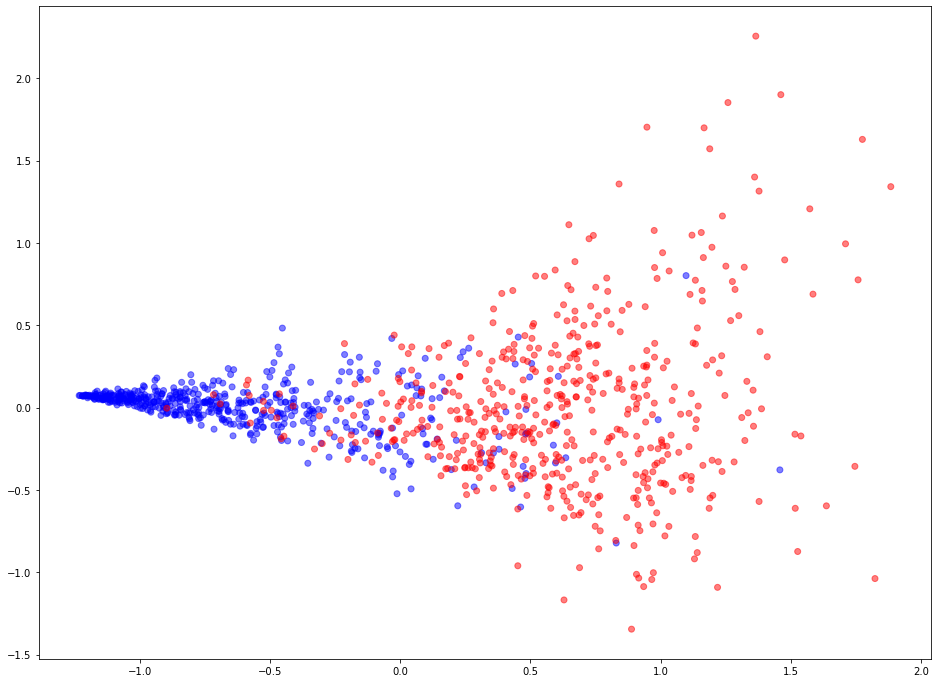

In [17]:
# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)

In [20]:
X_transformed

array([[-0.03651804, -0.18666871],
       [-1.20911913,  0.13097767],
       [-1.06318475,  0.09304707],
       ...,
       [ 1.36337131, -0.26040829],
       [-0.17859724, -0.28011831],
       [ 1.07271167,  0.10921767]])

In [21]:
labels_test

array([1, 1, 1, ..., 0, 0, 0])

**References:**
* [Examples of Link prediction](https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/index.html)

* https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/node2vec-link-prediction.html

[check ]https://towardsdatascience.com/link-prediction-with-neo4j-part-2-predicting-co-authors-using-scikit-learn-78b42356b44c